In [1]:
import numpy as np
import scipy
import scipy.stats as ss
# from scipy.optimize import minimize 
# from scipy.integrate import odeint
# import sympy
import joblib
from matplotlib import pyplot as plt
%matplotlib inline

# Import my GP toolbox
import GPtools as gpt

In [2]:
print(np.__version__,', ', scipy.__version__)

1.23.3 ,  1.9.3


# True system

In [3]:
# Properties 
m_amp = 4e4
m = 1 # mass (1; 4*10^4); 20 (my)
c = 5e3/m_amp # damping (2*0.03*np.pi; 5000); 4 (my)
k = 1e6/m_amp # stifness (np.pi**2; 10^6); 5 (my)

# Model properties
def naturalFreq(m,k):
    return(np.sqrt(k/m))

omega0 = naturalFreq(m,k)
print('Natural frequency:', round(omega0,3))

Natural frequency: 5.0


# Time-dependent natural frequency observations

In [4]:
timeOfDay_time = np.arange(0,24+0.1,0.1).reshape(-1,1)
timeOfDay_rad = timeOfDay_time * (2*np.pi/24)
m_t = m*(1 + 0.1*np.sin(timeOfDay_rad))
N=30
np.random.seed(42)
ind_obs = np.sort(np.random.randint(low=0, high=len(timeOfDay_time), size=N))
time_obs = timeOfDay_time[ind_obs]
rad_obs = timeOfDay_rad[ind_obs]
m_t_obs = m_t[ind_obs]

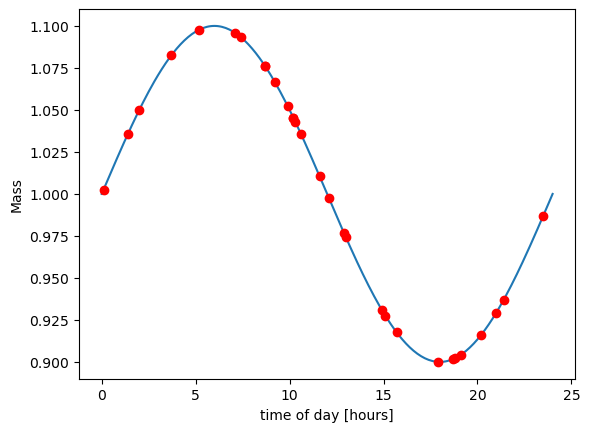

In [5]:
plt.plot(timeOfDay_time, m_t)
plt.plot(timeOfDay_time[ind_obs], m_t_obs, 'or')
plt.xlabel('time of day [hours]')
plt.ylabel('Mass')
plt.show()

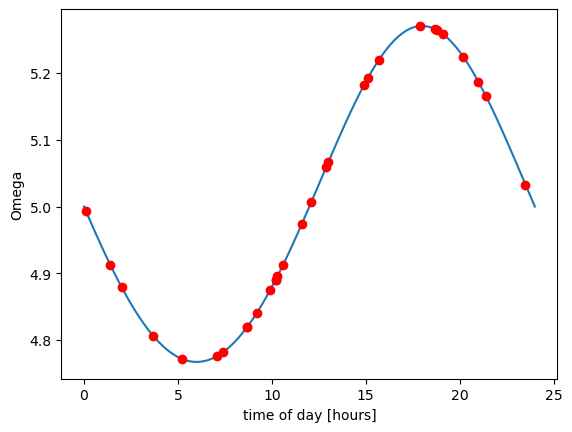

In [6]:
omega0_t_obs_noErr = naturalFreq(m_t_obs,k)
plt.plot(timeOfDay_time, naturalFreq(m_t, k))
plt.plot(time_obs, omega0_t_obs_noErr, 'or')
plt.xlabel('time of day [hours]')
plt.ylabel('Omega')
plt.show()

In [7]:
np.random.seed(123)
noise_std = 0.01 * omega0
noise_var = noise_std**2
omega0_t_obs = (omega0_t_obs_noErr + noise_std * np.random.normal(size=(N,1)) )

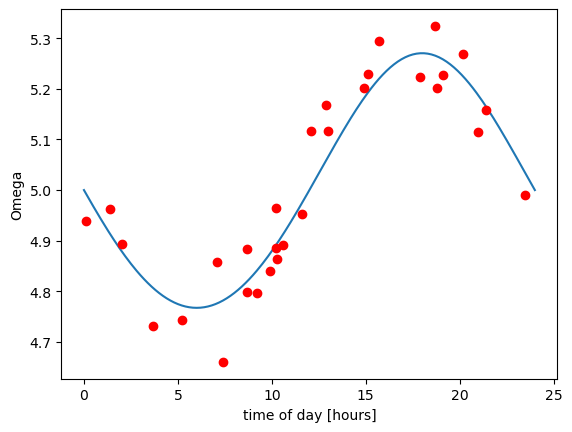

In [8]:
plt.plot(timeOfDay_time, naturalFreq(m_t, k))
plt.plot(timeOfDay_time[ind_obs], omega0_t_obs, 'or')
plt.xlabel('time of day [hours]')
plt.ylabel('Omega')
plt.show()

In [9]:
Xtr = np.hstack([np.cos(rad_obs), np.sin(rad_obs)])
Xte = np.hstack([np.cos(timeOfDay_rad), np.sin(timeOfDay_rad)])
ytr = omega0_t_obs

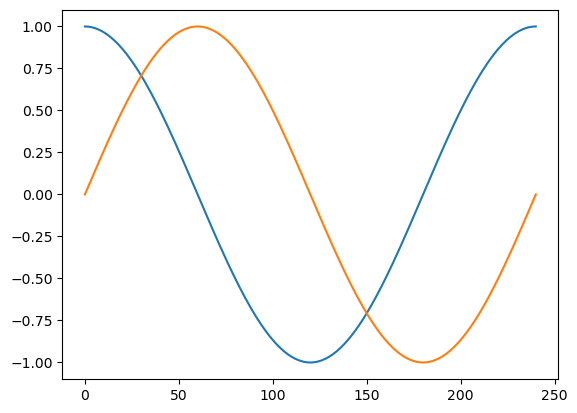

In [10]:
plt.plot(np.cos(timeOfDay_rad))
plt.plot(np.sin(timeOfDay_rad))
plt.show()

# Bayesian calibration model

The Bayesian calibration model of Kennedy and O’Hagan (KOH) defines the observed response as

$$
y = g(\theta_g, x) + w(\theta_w, x) + \epsilon \ ; \quad \epsilon \sim \mathcal{N}(0,\sigma_{\epsilon})
$$

where $g(\theta_g, x)$ is the deterministic physics-based model of the phenomenon, $w(\theta_w, x)$ is the decrepancy function (Gaussian process), and $\epsilon$ is the observation noise process. The above equation can equivalently be formulated as

$$
y - g(\theta_g, x) = w(\theta_w, x) + \epsilon,
$$

which states the discrepancy process incl. observation errors on the right-hand side. Note that using this formulation, we can use the standard GP formulations for fitting this process, given that we include the unknown parameters of $g()$ in the sample process, which enables evaluation of the left-hand side. 

## Likelihood

See ``GPtools``

## Posterior

In [11]:
def logNorm2Norm_parameters(lm ,ls):
    phi = np.sqrt( ls**2 + lm**2 )
    nm = 2 * np.log(lm) - np.log(phi)  # mean of log(Y) 
    ns = np.sqrt( 2*np.log(phi) - 2*np.log(lm) ) # std dev of log(Y)
    return(nm,ns)

def logPosterior(theta, x, y, pri1, pri2, hypPri1, hypPri2):
    err = y - naturalFreq(theta[0], theta[1])
    # Transformed parameters
    pri1_trans = logNorm2Norm_parameters(*pri1) 
    pri2_trans = logNorm2Norm_parameters(*pri2) 
    # log marginal posterior
    logPos = (gpt.logMargLike(x, err, noise_var, *theta[2:])
              + ss.lognorm(s=pri1_trans[1], scale=np.exp(pri1_trans[0])).logpdf(theta[0])
              + ss.lognorm(s=pri2_trans[1], scale=np.exp(pri2_trans[0])).logpdf(theta[1])
              # + ss.invgamma(a = hypPri1[0], scale = hypPri1[1]).logpdf(theta[2]) 
              # + ss.invgamma(a = hypPri2[0], scale = hypPri2[1]).logpdf(theta[3]) 
              + ss.uniform(loc = hypPri1[0], scale = hypPri1[1]).logpdf(theta[2]) 
              + ss.uniform(loc = hypPri1[0], scale = hypPri1[1]).logpdf(theta[3]) 
             ) 
    return(logPos)
# print(logPosterior(np.array([m, k, 0.01, 0.01]), time_obs, omega0_t_obs, [m,1], [k,1], [2,2], [2,2]))

# def logPosJacobien(theta, x=Xtr, y=ytr, pri1 = [m*1.25, 0.5*m], pri2 = [k*1.25, 0.5*k], hypPri1=[2,1], hypPri2=[2,1]): # invgamma
def logPosJacobien(theta, x=Xtr, y=ytr, pri1 = [m*1.25, 0.5*m], pri2 = [k*1.25, 0.5*k], hypPri1=[0,2], hypPri2=[0.5,15.5]): # uniform
    ttheta = np.exp(theta) # true range [0, inf]
    logPosJac = (logPosterior(ttheta, x, y, pri1, pri2, hypPri1, hypPri2)
                + sum( theta ) # sampled in log space, i.e., theta == np.log( ttheta )
                )
    return(logPosJac)
# print(logPosJacobien(np.log(np.array([m, k, 0.01, 0.01]))))    

In [12]:
def calc_max_pdf_mode(data, plot=False):
    kde_dist = ss.gaussian_kde(data)
    x_domain = np.linspace(min(data), max(data), 1000)
    y_pdf = kde_dist.pdf(x_domain)
    i = np.argmax(y_pdf)
    
    if (plot==True):
        plt.plot(x_domain, y_pdf, linewidth=2)
        plt.plot(x_domain[i], y_pdf[i], 'or')    
    
    return(x_domain[i])

# calc_max_pdf_mode(np.exp(samp_pos[:,0]), plot=True)

0.9942604254887835


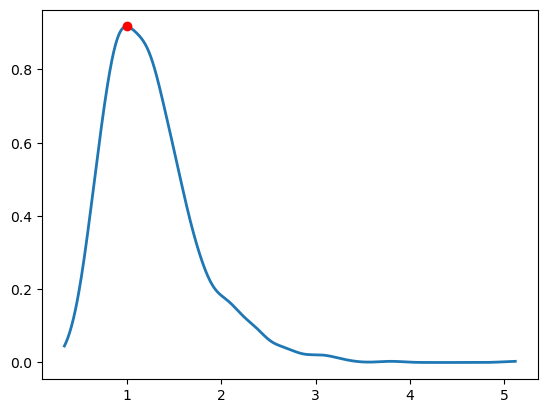

24.856510637219564


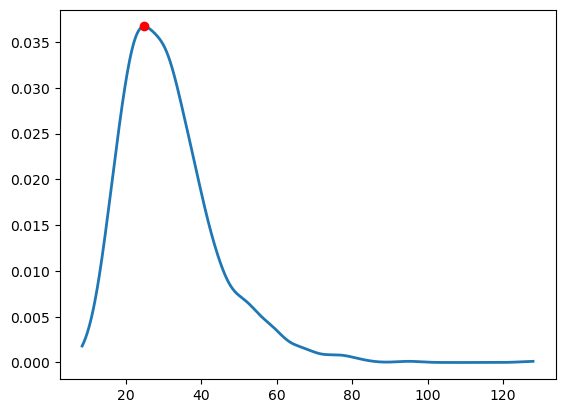

In [13]:
tp1_pri_plot = logNorm2Norm_parameters(m*1.25 ,0.5*m)
tp2_pri_plot = logNorm2Norm_parameters(k*1.25 ,0.5*k)

tp1_pri_samp_plot = ss.lognorm(s=tp1_pri_plot[1], scale=np.exp(tp1_pri_plot[0])).rvs(size=1000, random_state=42)
print(calc_max_pdf_mode(tp1_pri_samp_plot, plot=True))
plt.show()

tp2_pri_samp_plot = ss.lognorm(s=tp2_pri_plot[1], scale=np.exp(tp2_pri_plot[0])).rvs(size=1000, random_state=42)
print(calc_max_pdf_mode(tp2_pri_samp_plot, plot=True))
plt.show()

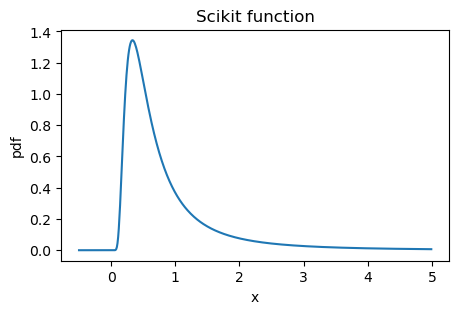

In [14]:
xx=np.arange(-0.5,5,0.01)
yy1=ss.invgamma.pdf(xx, a=2, scale=1)

plt.figure(figsize=(5, 3))
plt.plot(xx,yy1)
plt.xlabel('x')
plt.ylabel('pdf')
plt.title('Scikit function')
plt.show()

1.84682483552993

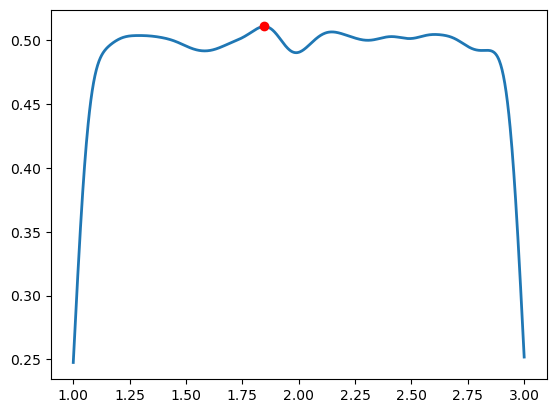

In [15]:
calc_max_pdf_mode(ss.uniform(loc=1, scale=2).rvs(size=100000), plot=True)

## MCMC sampling

In [16]:
# Metropolis algorithm
def Metropolis(x, T, Tburn, log_pos, delta=1, dim=1):
    counter=0
    samp = np.zeros([T, dim])
    samp[0] = x
    lp_cur = log_pos(x)
    for t in range(1,T,1):
        x_pro = samp[t-1] + np.random.normal(size=dim)*delta
        lp_pro = log_pos(x_pro)
        ratio_pro = lp_pro - lp_cur
        if np.log(np.random.uniform()) < ratio_pro: 
            if (t > Tburn): counter += 1
            samp[t] = x_pro
            lp_cur = lp_pro
        else:
            samp[t] = samp[t-1]
    return(samp, counter)

In [17]:
# Sampling
T=2000
Tburn=T//2
x0 = np.log( np.array([m*1.2, k*0.9, 1, 1]) )
# x0 = np.log( np.array([m, k, 1, 1, 1]) )
np.random.seed(42)          
samp, counter = Metropolis(x0, T, Tburn, logPosJacobien, delta=0.18, dim=len(x0)) # 0.2
print('Acceptance rate: ' , np.round(counter/Tburn,3))

Acceptance rate:  0.251


In [18]:
samp_burn = samp[:Tburn]
samp_pos = samp[Tburn:]

## Plot samples

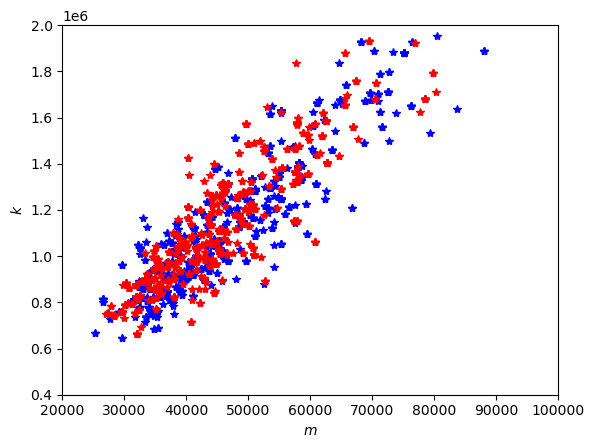

In [19]:
plt.figure()
# plt.plot(np.exp(samp_burn[:,0]), np.exp(samp_burn[:,1]), '*b')
# plt.plot(np.exp(samp_pos[:,0]), np.exp(samp_pos[:,1]), '*r')
# plt.axis([0.5,2,10,40])
plt.plot(np.exp(samp_burn[:,0])*m_amp, np.exp(samp_burn[:,1])*m_amp, '*b')
plt.plot(np.exp(samp_pos[:,0])*m_amp, np.exp(samp_pos[:,1])*m_amp, '*r')
plt.axis(np.array([0.5,2.5,10,50])*m_amp)
plt.ylabel('$k$')
plt.xlabel('$m$')
plt.show()

1.1159327452621763

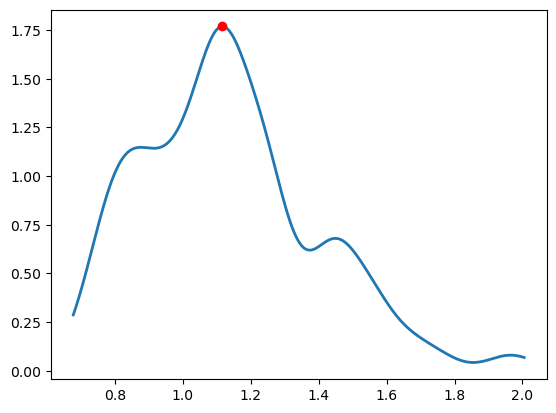

In [20]:
calc_max_pdf_mode(np.exp(samp_pos[:,0]), plot=True)

25.335815991215043

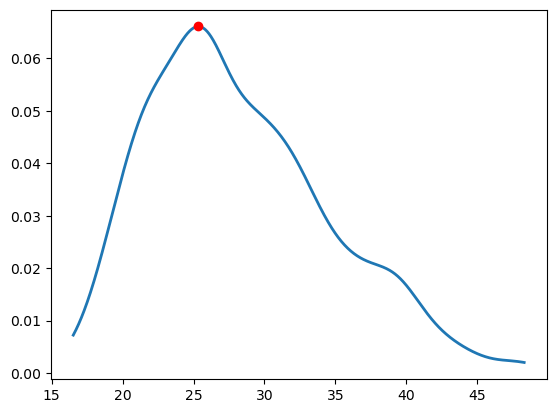

In [21]:
calc_max_pdf_mode(np.exp(samp_pos[:,1]), plot=True)

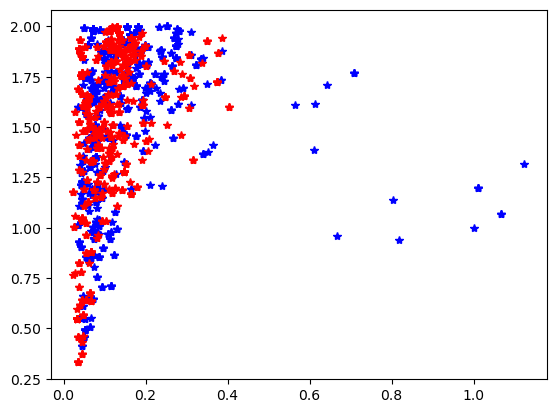

In [22]:
plt.plot(np.exp(samp_burn[:,2]), np.exp(samp_burn[:,3]), '*b')
plt.plot(np.exp(samp_pos[:,2]), np.exp(samp_pos[:,3]), '*r')
plt.show()

0.05071243629789254

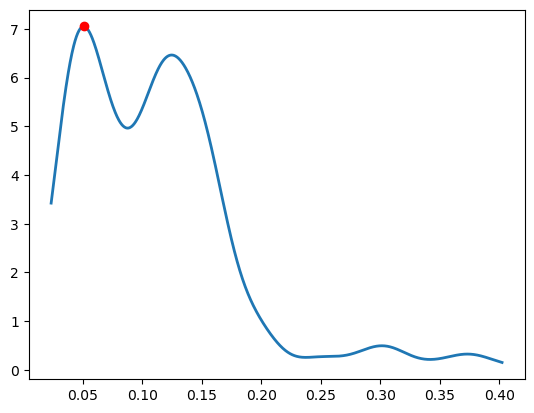

In [23]:
calc_max_pdf_mode(np.exp(samp_pos[:,2]), plot=True)

1.845744828298384

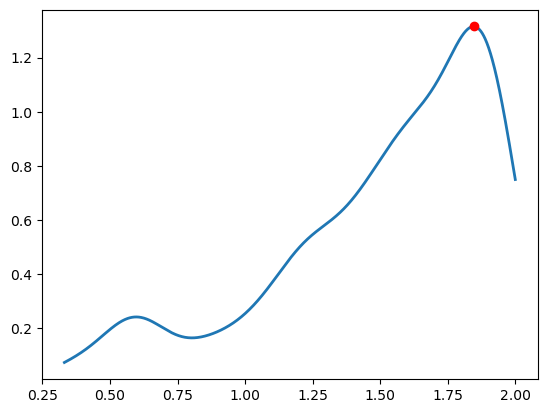

In [24]:
calc_max_pdf_mode(np.exp(samp_pos[:,3]), plot=True)

## Fully Bayesian inference

In [25]:
n_samp = samp_pos.shape[0]
m_points = Xte.shape[0]

mu_mdl_samples = np.zeros(( n_samp , m_points ))
mu_dis_samples = np.zeros(( n_samp , m_points )) 
sig_dis_samples = np.zeros(( n_samp, m_points )) 
samp_dis_samples = np.zeros(( n_samp, m_points )) 

for i in range(n_samp):
    par_vec_i = np.exp(samp_pos[i,:]) # parameters in true scale 
    mdl_pred = naturalFreq(*par_vec_i[:2]) # model prediction
    dis_pred = ytr - mdl_pred
    # Kernel evaluations
    K = gpt.se_kern(Xtr, Xtr, *par_vec_i[2:])
    K_s = gpt.se_kern(Xtr, Xte, *par_vec_i[2:])
    K_ss = gpt.se_kern(Xte, Xte, *par_vec_i[2:])
    # Apply the kernel function to our training points
    L = np.linalg.cholesky(K + np.eye(N)*noise_var)
    # predictive mean
    alp_m = np.linalg.solve(L.T,np.linalg.solve(L, dis_pred))
    mu_pos = np.dot(K_s.T, alp_m)
    # predictive variance
    vv_m = np.linalg.solve(L,K_s)
    cov_pos = K_ss - vv_m.T.dot(vv_m)
    sig_pos = (np.diag(cov_pos)**(0.5)).reshape(-1,1)
    
    # Draw one sample from the posterior at test points.
    L_pos = np.linalg.cholesky(cov_pos + (1e-8)*np.eye(m_points))
    f_pos = mu_pos + np.dot(L_pos, np.random.normal(size=(m_points, 1)))
    
    mu_mdl_samples[i] = mdl_pred.T
    mu_dis_samples[i] = mu_pos.T
    sig_dis_samples[i] = sig_pos.T
    samp_dis_samples[i] = f_pos.T

In [26]:
# Define sample statistics for the latent function (f) and the output (y)
# np.random.seed(123)
mdlf_stats = np.zeros((m_points,3))
y_stats = np.zeros((m_points,3))
# noise_y = np.random.normal(np.zeros(n_samp))
for i in range(m_points):
    mdl_samp_i = mu_mdl_samples[:,i]
    f_samp_i = mu_dis_samples[:,i]
    mdlf_samp_i = mdl_samp_i + f_samp_i
    mdlf_samp_i_m = np.mean(mdlf_samp_i)
    # mdlf_samp_i_q = np.quantile(mdlf_samp_i, [0.025, 0.975])
    mdlf_samp_i_v = np.var(mdlf_samp_i)
    mdlf_samp_i_q = mdlf_samp_i_m + 2 * np.array([-1,1]) * np.sqrt(mdlf_samp_i_v)
    mdlf_stats[i] = np.concatenate(([mdlf_samp_i_m], mdlf_samp_i_q), axis=0)
    
    # y_samp_i =  mdlf_samp_i + noise_y * sig_dis_samples[:,i]
    # y_samp_i_m = np.mean(y_samp_i)
    y_samp_i_m =  mdlf_samp_i_m
    # y_samp_i_q = np.quantile(y_samp_i, [0.025, 0.975])
    y_samp_i_q = y_samp_i_m + 2 * np.array([-1,1]) * np.sqrt(mdlf_samp_i_v + np.mean(sig_dis_samples[:,i])**2)
    y_stats[i,:] = np.concatenate(([y_samp_i_m], y_samp_i_q), axis=0)

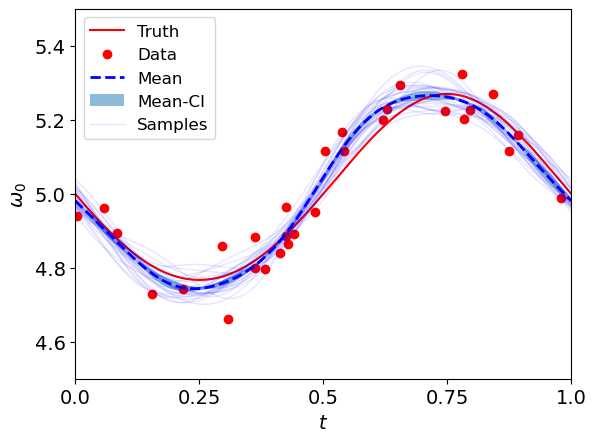

In [60]:
# Ground truth
plt.plot(timeOfDay_time, naturalFreq(m_t, k), '-r')
# Plot training and test data
plt.plot(time_obs[:,0], ytr, 'ro')
# plt.plot(Xtest, ytest, 'gs', ms=3);
# Predictive mean
plt.plot(timeOfDay_time[:,0], mdlf_stats[:,0], 'b--', lw=2)
# Shade in credible region
plt.fill_between(timeOfDay_time[:,0], mdlf_stats[:,1], mdlf_stats[:,2], alpha=0.5)
# plt.fill_between(timeOfDay_time[:,0], y_stats[:,1], y_stats[:,2], alpha=0.1, color='blue')
# Samples from the posterior
# for i in [6,9,56,111,300]:
for i in range(30):
    plt.plot(timeOfDay_time[:,0], mu_mdl_samples[i] + samp_dis_samples[i], 'b-', lw=1, alpha=0.1)
# plt.plot(timeOfDay_time[:,0], np.mean(mu_mdl_samples, axis=0))
plt.axis([0, 24, 4.5, 5.5])
# plt.xticks(np.arange(0, 28, 4), fontsize=14)
plt.xticks(ticks=np.arange(0, 26, 6), labels=np.arange(0, 1.25, 0.25), fontsize=14)
plt.yticks(fontsize=14)
# plt.xlabel('$t$ [hours]', fontsize=14)
plt.xlabel('$t$', fontsize=14)
plt.ylabel('$\omega_0$', fontsize=14)
# plt.title('Posterior distribution along with the training data')
plt.legend(['Truth','Data', 'Mean', 'Mean-CI', 'Samples'], fontsize=12)
# plt.legend(['Data', 'Mean', '95% CI (f)', '95% CI (y)', 'Samples'])
# plt.show()

# save plot to pdf
# plt.savefig('calibration_pridictive_mcmc.pdf', bbox_inches='tight')

## MAP inference

In [28]:
samp_pos_map = [calc_max_pdf_mode(item) for item in np.exp(samp_pos).T]; print(samp_pos_map)
mu_pos_map, cov_pos_map = gpt.compute_pos(Xtr, ytr - naturalFreq(*samp_pos_map[:2]), Xte, noise_var, *samp_pos_map[2:])

[1.1159327452621763, 25.335815991215043, 0.05071243629789254, 1.845744828298384]


In [29]:
np.random.seed(123)
f_samp_map = gpt.sample_pos(mu_pos_map, cov_pos_map, 10)

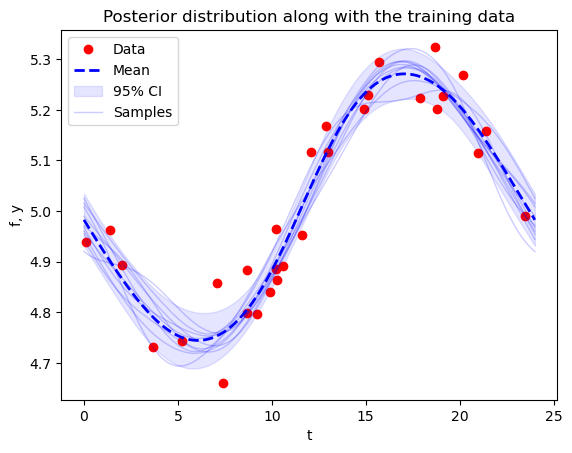

In [30]:
# plotting function
def plot_pos_map(Xtr, ytr, Xte, mu_pos, std_pos, f_samp):
    mdl_map = naturalFreq(*samp_pos_map[:2])
    plt.plot(Xtr, ytr, 'ro')
    plt.plot(Xte, mdl_map + mu_pos, 'b--', lw=2)
    plt.fill_between(x=Xte[:,0], y1=mdl_map + (mu_pos[:,0]-2*std_pos[:,0]), y2=mdl_map + (mu_pos[:,0]+2*std_pos[:,0]), alpha=0.1, color='blue')
    plt.plot(Xte, mdl_map + f_samp, 'b-', lw=1, alpha=0.2)
    # plt.axis([0, 24, 0.3, 0.7])
    plt.xlabel('t')
    plt.ylabel('f, y')
    plt.title('Posterior distribution along with the training data')
    plt.legend(['Data', 'Mean', '95% CI', 'Samples'])
    plt.show()

plot_pos_map(time_obs, ytr, timeOfDay_time, mu_pos_map, (np.diag(cov_pos_map)**(0.5)).reshape(-1,1), f_samp_map)